Import of libraries

In [1]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In total, the dataset contains 159 objects. We have reserved a part of the dataset for the baseline task. In this assignment, it is assumed to work with a dataset containing 119 objects.

# 0. Application of polynomial regression to predict a continuous parameter

The provided dataset consists of seven different types of fish sold in some fish shop. The goal is to predict the mass of the fish from some indirect features known about the fish. The features themselves may need to be synthesized from those that are known.

In [2]:
df2 = pd.read_csv("fish_train.csv")
df2.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Roach,150.0,20.4,22.0,24.7,5.8045,3.7544
1,Perch,250.0,25.4,27.5,28.9,7.2828,4.5662
2,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
3,Bream,925.0,36.2,39.5,45.3,18.7542,6.7497
4,Perch,110.0,19.0,21.0,22.5,5.6925,3.5550


In [71]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  119 non-null    object 
 1   Weight   119 non-null    float64
 2   Length1  119 non-null    float64
 3   Length2  119 non-null    float64
 4   Length3  119 non-null    float64
 5   Height   119 non-null    float64
 6   Width    119 non-null    float64
dtypes: float64(6), object(1)
memory usage: 6.6+ KB


In [72]:
df2.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,119.000000,119.000000,119.000000,119.000000,119.000000,119.000000
mean,405.177311,26.594958,28.781513,31.602521,9.092096,4.507407
std,338.834252,9.613002,10.308208,11.116086,4.231866,1.678796
min,0.000000,7.500000,8.400000,8.800000,1.738800,1.047600
25%,142.500000,20.000000,22.000000,23.500000,6.138850,3.536400
50%,300.000000,25.400000,27.500000,30.600000,8.145400,4.335000
75%,685.000000,33.850000,36.450000,40.150000,12.143400,5.789550
max,1550.000000,56.000000,60.000000,64.000000,18.957000,8.142000


Use <code>train_test_split()</code> to split the dataset into training and test samples with the parameters specified in your assignment. Use stratification by column <code>Species</code>. Stratification will maintain the proportions of represented objects (by fish type representatives) in the training and test samples.

In [3]:
X = df2.drop(columns=['Species', 'Weight'])
Y = df2['Weight']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=27, stratify=df2['Species'])

Find sample mean for the column <code>Width</code> of the obtained training sample.

In [5]:
print(round(X_train['Width'].mean(),3))

4.558


# 1. Building a base model

Remove categorical features and train a linear regression model (<code>LinearRegression()</code>) on the training dataset. Perform predictions on the test dataset. 
Evaluate the model using the metric <code>r2_score()</code>.

In [6]:
base_model = LinearRegression().fit(X_train, y_train)
print(round(r2_score(y_test, base_model.predict(X_test)),3))

0.801


# 2. Adding feature preprocessing

## Use of PCA

Using, for example, <code>sns.heatmap()</code>, construct a feature correlation matrix of the training dataset and identify the top three most correlated features.

<Axes: >

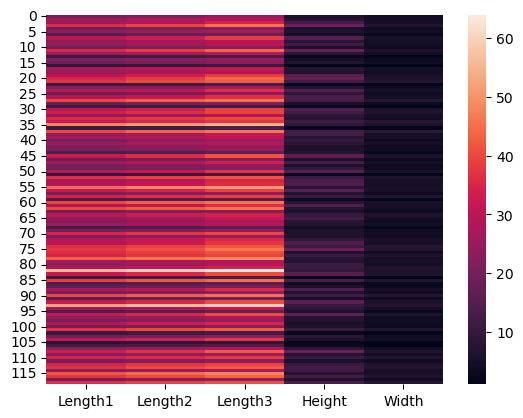

In [77]:
sns.heatmap(X)

Linear models respond rather poorly to correlated features, so it makes sense to get rid of such features before training begins.

Use the principal component analysis to reduce the number of uninformative dimensions.

1) Apply the principal component analysis (<code>PCA(n_components=3, svd_solver='full')</code>) to the three most correlated features found. 

2) Calculate the explained variance ratio when using only the first principal component.

3) Replace the top three most correlated features with the new feature <code>Lengths</code> whose values coincide with the scores for the first principal component.

In [7]:
pca_3 = PCA(n_components=3, svd_solver='full')
pca_3.fit(X_train[['Length1', 'Length2', 'Length3']])
Length_pca = pca_3.transform(X_train[['Length1', 'Length2', 'Length3']])
X_train['Length_pca'] = Length_pca[:,0]
# Length_pca_train = pca_3.transform(X_train[['Length1', 'Length2', 'Length3']])

In [8]:
X_train = X_train.drop(columns = ['Length1', 'Length2', 'Length3'])

In [9]:
pca_3.explained_variance_ratio_

array([9.96321244e-01, 3.57673764e-03, 1.02018590e-04])

In [10]:
X_test['Length_pca'] = pca_3.transform(X_test[['Length1', 'Length2', 'Length3']])[:,0]
X_test = X_test.drop(columns=['Length1', 'Length2', 'Length3'])

Apply the obtained transformation for the same features in the test dataset. Note that it is not necessary to re-train the `PCA` transformation. Similarly to the previous step, replace the three considered features by one.

Train a basic linear regression model on the obtained training dataset, again discarding categorical features. Perform predictions on the test dataset and evaluate the model using <code>r2_score()</code>.

In [11]:
base_model_pca = LinearRegression().fit(X_train, y_train)
print(round(r2_score(y_test, base_model_pca.predict(X_test)),3))

0.783


It can be seen that the quality of the model has not changed significantly.

## Feature engineering

Plot the dependencies of the features on the target feature, e.g., by using <code>sns.pairplot()</code>.

/Users/roman14/.conda/envs/Pycharm/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


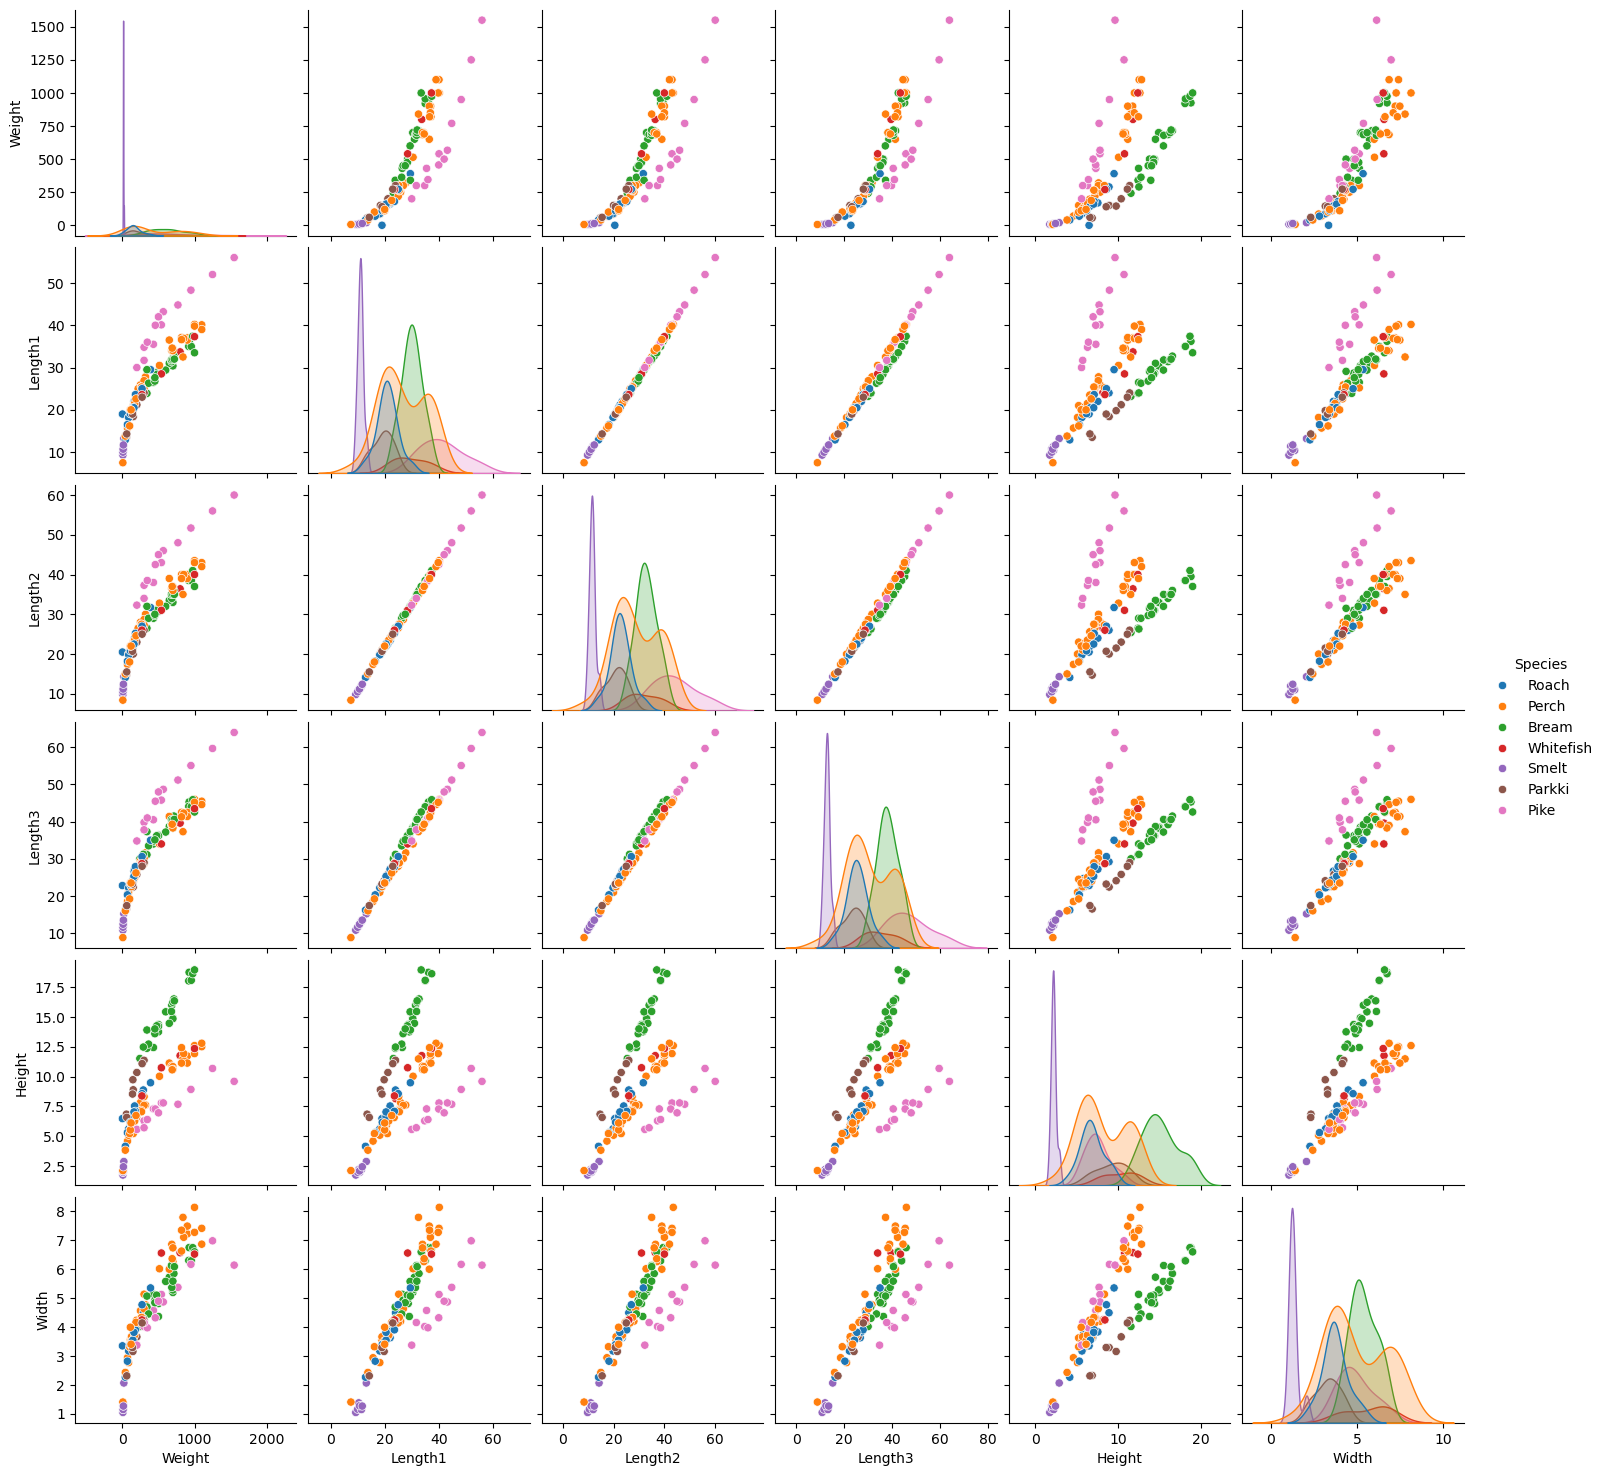

In [96]:
sns.pairplot(df2, hue='Species')

It can be seen that the mass, in general, does not depend linearly on the other features. So, in order for the linear model to do a proper predictions, it makes sense to transform the features so that the dependence becomes more similar to a linear one. But how to come up with such a dependence?

It is logical to assume that the mass of a fish should somehow smoothly depend on the other parameters responsible in one way or another for its size. If we remember that mass is the product of density by volume, then

$$
m = \rho \cdot V.
$$

Suppose that the average density of all fish is the same, and recall that in homothety the volume of the object depends on the linear dimensions as a cube, then we obtain

$$
m\sim V\sim d^3
$$

Take to the third degree all the features of training and test datasets that are responsible in one way or another for the fish size (<code>Height, Width, Lengths</code>), and check whether the dependence of mass on these features has become linear.

In [17]:
X_train_cube = X_train.apply(lambda x: x**3)
X_test_cube = X_test.apply(lambda x: x**3)

Enter the sample mean for the column <code>Width</code> of the training dataset after cubeization.

In [13]:
print(f'Sample mean for the columns Width = {round(X_train_cube["Width"].mean(), 3)}')

Sample mean for the columns Width = 135.621


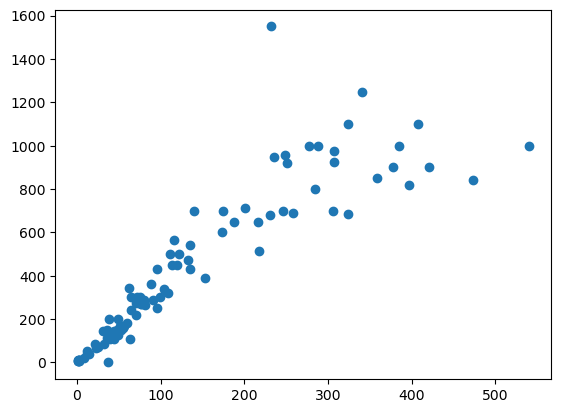

In [16]:
import matplotlib.pyplot as plt
plt.scatter(X_train_cube.Width, y_train)

Choose the images corresponding to the dependence of <code>Weight</code> on <code>Width</code> before the transformation and after.

Train a basic linear regression model on the obtained training dataset, again discarding categorical features. Perform predictions for the test dataset, evaluate the model using `r2_score()`.

In [18]:
base_model_cube = LinearRegression().fit(X_train_cube, y_train)
print(round(r2_score(y_test, base_model_cube.predict(X_test_cube)),3))

0.89


Note how such uncomplicated feature work helped dramatically improve the quality of the model!

## Adding categorical features

Add the previously excluded categorical features to the dataset obtained in the previous step, having previously performed one-hot encoding using pd.get_dummies(). Train the linear regression model. Enter r2_score() of the obtained model.

Perform the <code>one-hot</code> encoding of the categorial feature `Species`, e.g., using <code>pd.get_dummies()</code>.

Train a linear regression model on the obtained training dataset. Perform predictions for the test dataset, evaluate the model using the <code>r2_score()</code>.

<b>Note</b>: We purposely used stratified splitting so that all values of a categorical feature <code>Species</code> are present in all datasets. But this is not always possible. You can read about how to deal with this problem, for example, [here](https://predictivehacks.com/?all-tips=how-to-deal-with-get_dummies-in-train-and-test-dataset).

In [25]:
result_train = pd.concat([X_train_cube, df2['Species']], axis = 1, join='inner')
result_train = pd.get_dummies(result_train)
result_train.head()

,Height,Width,Length_pca,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
40,1107.368679,49.172711,-1011.042097,False,True,False,False,False,False,False
15,271.493578,37.649269,-3053.497880,False,False,False,False,True,False,False
8,540.427262,76.684372,-79.851350,False,False,False,False,False,False,True
38,1896.401907,103.564761,-35.971574,True,False,False,False,False,False,False
30,3032.129192,187.896219,785.600211,True,False,False,False,False,False,False


In [24]:
result_test = pd.concat([X_test_cube, df2['Species']], axis = 1, join='inner')
result_test = pd.get_dummies(result_test)
result_test.head()

,Height,Width,Length_pca,Species_Bream,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
96,4380.192923,225.866529,1643.082965,True,False,False,False,False,False,False
5,282.429536,76.171104,-283.178966,False,False,True,False,False,False,False
12,478.285155,74.310486,-14.118154,False,False,True,False,False,False,False
109,305.283438,72.292833,-535.141438,False,False,True,False,False,False,False
55,452.984832,155.373797,34928.932800,False,False,False,True,False,False,False


In [26]:
base_model_dummy = LinearRegression().fit(result_train, y_train)
print(round(r2_score(y_test, base_model_dummy.predict(result_test)),3))

0.902


Once again, the quality has increased.

It can be seen that after `one-hot` encoding the features became correlated. You can get rid of this, for example, by using the `drop_first=True` parameter. Re-train the model after correcting this flaw. Perform predictions for the test dataset, evaluate the model using <code>r2_score()</code>.

In [31]:
result_train = pd.concat([X_train_cube, df2['Species']], axis = 1, join='inner')
result_train = pd.get_dummies(result_train, drop_first=True)

result_test = pd.concat([X_test_cube, df2['Species']], axis = 1, join='inner')
result_test = pd.get_dummies(result_test, drop_first=True)

In [34]:
result_test.head(10)

,Height,Width,Length_pca,Species_Parkki,Species_Perch,Species_Pike,Species_Roach,Species_Smelt,Species_Whitefish
96,4380.192923,225.866529,1643.082965,False,False,False,False,False,False
5,282.429536,76.171104,-283.178966,False,True,False,False,False,False
12,478.285155,74.310486,-14.118154,False,True,False,False,False,False
109,305.283438,72.292833,-535.141438,False,True,False,False,False,False
55,452.984832,155.373797,34928.932800,False,False,True,False,False,False
19,3281.644247,147.650044,586.544085,False,False,False,False,False,False
84,10.712016,1.514536,-25419.484745,False,False,False,False,True,False
91,142.432927,36.647301,-7611.648566,False,True,False,False,False,False
67,368.170147,81.464295,-35.334851,False,True,False,False,False,False
115,337.153536,117.361115,20762.191925,False,False,True,False,False,False


In [35]:
final_model = LinearRegression().fit(result_train, y_train)
print(round(r2_score(y_test, final_model.predict(result_test)),3))

0.902


On such a relatively small dataset, though, we see no difference.